# multi-task alternate training strategy--clearence prediction

In [2]:
from molmap import loadmap, dataset
import molmap

import matplotlib.pyplot as plt
from joblib import dump, load
from tqdm import tqdm
import pandas as pd
tqdm.pandas(ascii=True)

import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import MaxPool2D, GlobalMaxPool2D, BatchNormalization, Activation
from tensorflow.keras.layers import Conv2D, Concatenate,Flatten, Dense, Dropout

%matplotlib inline
#use the second GPU, if negative value, CPUs will be used
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"


In [3]:
# just for repeatable results
seed = 1234
np.random.seed(seed)
tf.set_random_seed(seed)

In [4]:

def Inception(inputs, units = 8, strides = 1):
    """
    naive google inception block
    """
    x1 = Conv2D(units, 5, padding='same', activation = 'relu', strides = strides)(inputs)
    x2 = Conv2D(units, 3, padding='same', activation = 'relu', strides = strides)(inputs)
    x3 = Conv2D(units, 1, padding='same', activation = 'relu', strides = strides)(inputs)
    outputs = Concatenate()([x1, x2, x3])    
    return outputs


def DoublePathModel(molmap1_size, molmap2_size, n_outputs = 1):
    
    ## first inputs
    d_inputs1 = Input(molmap1_size)
    d_conv1 = Conv2D(48, 13, padding = 'same', activation='relu', strides = 1)(d_inputs1)
    d_pool1 = MaxPool2D(pool_size = 3, strides = 2, padding = 'same')(d_conv1) #p1
    d_incept1 = Inception(d_pool1, strides = 1, units = 32)
    d_pool2 = MaxPool2D(pool_size = 3, strides = 2, padding = 'same')(d_incept1) #p2
    d_incept2 = Inception(d_pool2, strides = 1, units = 64)
    d_flat1 = GlobalMaxPool2D()(d_incept2)

    
    ## second inputs
    f_inputs1 = Input(molmap2_size)
    f_conv1 = Conv2D(48, 13, padding = 'same', activation='relu', strides = 1)(f_inputs1)
    f_pool1 = MaxPool2D(pool_size = 3, strides = 2, padding = 'same')(f_conv1) #p1
    f_incept1 = Inception(f_pool1, strides = 1, units = 32)
    f_pool2 = MaxPool2D(pool_size = 3, strides = 2, padding = 'same')(f_incept1) #p2
    f_incept2 = Inception(f_pool2, strides = 1, units = 64)
    f_flat1 = GlobalMaxPool2D()(f_incept2)    
    
    ## concat
    merge = Concatenate()([d_flat1, f_flat1]) 
    d1 = Dense(256,activation='relu')(merge)
    d1 = Dense(128,activation='relu')(d1)
    d1 = Dense(64,activation='relu')(d1)
    outputs = Dense(n_outputs, activation='linear')(d1)
    
    model = tf.keras.Model(inputs=[d_inputs1, f_inputs1], outputs=outputs)
    
    return model

In [5]:
df = pd.read_csv('./Dataset_chembl_clearcaco.txt',sep=';')

# featurizer

In [6]:
X1_name =  './X_descriptor.data'
X2_name =  './X_fingerprint.data'
X_smiles = df.Canonical_Smiles.tolist()

if os.path.exists(X1_name):
    X1 = load(X1_name)
else:
    mp1 = loadmap('../descriptor_grid_split.mp')
    X1 = mp1.batch_transform(X_smiles, n_jobs = 8)
    dump(X1, X1_name)
    
if os.path.exists(X2_name):
    X2 = load(X2_name)
else:
    mp2 = loadmap('../fingerprint_grid_split.mp')
    X2 = mp2.batch_transform(X_smiles, n_jobs = 8)
    dump(X2, X2_name)

In [7]:
def get_idx_and_Y(df, task, split):
    train_idx = df[df[split] == 'Train'].index
    valid_idx = df[df[split] == 'Test'].index ##according to the paper<page 1256, Data Preparation>, they use this for early stopping
    test_idx = df[df[split] == 'Ext'].index #their Ext set is our final test set
    def _apply_float(x):
        if type(x) == float:
            return x
        else:
            x = x.replace(',','.')
            return float(x)
    Y = df[task].apply(_apply_float).to_frame().values
    Y = np.log10(Y + 1e-8)
    print(len(train_idx), len(valid_idx), len(test_idx))
    return (train_idx, valid_idx, test_idx), Y

In [8]:
df.columns

Index(['ID', 'Canonical_Smiles', 'hlm_clearance[mL.min-1.g-1]',
       'rlm_clearance[mL.min-1.g-1]', 'mlm_clearance[mL.min-1.g-1]',
       'caco2_PAPP[10^-7cm/s]', 'Set_hlm', 'Set_rlm', 'Set_mlm', 'Set_caco'],
      dtype='object')

In [9]:
t = ['hlm_clearance[mL.min-1.g-1]','rlm_clearance[mL.min-1.g-1]', 'mlm_clearance[mL.min-1.g-1]']
m = ['Set_hlm', 'Set_rlm', 'Set_mlm']


task_epochs = 500
alternate_epochs = 1
alternate_rounds = 40

In [10]:
from sklearn.utils import shuffle
basemodel_data = []
for i, j in zip(t, m):
    (train_idx, valid_idx, test_idx), Y = get_idx_and_Y(df, i, j)
    trainY = Y[train_idx]
    trainX = (X1[train_idx], X2[train_idx])
    basemodel_data.append([trainX, trainY])

4020 801 527
1636 331 199
617 117 56


## alternate strategy to train a base model

In [11]:
model = None
for i in tqdm(range(alternate_rounds)):
    basemodel_data = shuffle(basemodel_data) #shffule
    for trainX,trainY in basemodel_data:
        if model == None:
            molmap1_size = X1.shape[1:]
            molmap2_size = X2.shape[1:]
            model = DoublePathModel(molmap1_size, molmap2_size, n_outputs = trainY.shape[1])
            lr = tf.keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0) #
            model.compile(optimizer = lr, loss = 'mse')
        model.fit(trainX, trainY, batch_size=128, epochs=alternate_epochs, verbose= 0, shuffle = True) #
        
model.save('./basemodel.h5')

  0%|          | 0/40 [00:00<?, ?it/s]

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


100%|██████████| 40/40 [00:57<00:00,  1.24s/it]


## 01.branch training for task of hlm

In [12]:
task = 'hlm_clearance[mL.min-1.g-1]'
split = 'Set_hlm'

(train_idx, valid_idx, test_idx), Y = get_idx_and_Y(df, task, split)

trainY = Y[train_idx]
validY = Y[valid_idx]
testY = Y[test_idx]

trainX = (X1[train_idx], X2[train_idx])
validX = (X1[valid_idx], X2[valid_idx])
testX  = (X1[test_idx], X2[test_idx])

#model = DoublePathModel(molmap1_size, molmap2_size, n_outputs = Y.shape[1])
#model = SinglePathModel(molmap_size, n_outputs = Y.shape[1])
from cbks import RegressionPerformance, EarlyStoppingAtMinLoss

earlystop = EarlyStoppingAtMinLoss(patience=10, criteria = 'val_loss')
performace = RegressionPerformance((trainX, trainY), (validX, validY), MASK = 1e8)
lr = tf.keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0) #
#model.compile(optimizer = lr, loss = 'mse')


model.load_weights('./basemodel.h5')
model.fit(trainX, trainY, batch_size=128, 
      epochs=task_epochs, verbose= 0, shuffle = True, 
      validation_data = (validX, validY), 
      callbacks=[performace, earlystop]) #

4020 801 527
epoch: 0001, loss: 0.0643 - val_loss: 0.1738; rmse: 0.2062 - rmse_val: 0.4169;  r2: 0.9115 - r2_val: 0.6138                                                                                                    
epoch: 0002, loss: 0.0430 - val_loss: 0.1704; rmse: 0.1913 - rmse_val: 0.4128;  r2: 0.9238 - r2_val: 0.6198                                                                                                    
epoch: 0003, loss: 0.0407 - val_loss: 0.1756; rmse: 0.1922 - rmse_val: 0.4190;  r2: 0.9311 - r2_val: 0.6196                                                                                                    
epoch: 0004, loss: 0.0330 - val_loss: 0.1658; rmse: 0.1673 - rmse_val: 0.4072;  r2: 0.9383 - r2_val: 0.6265                                                                                                    
epoch: 0005, loss: 0.0294 - val_loss: 0.1655; rmse: 0.1580 - rmse_val: 0.4068;  r2: 0.9446 - r2_val: 0.6269                                                

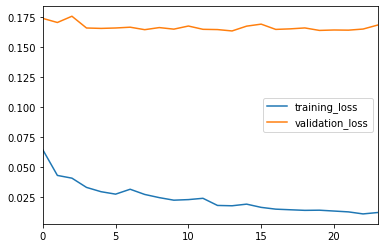

In [13]:
dfp = pd.DataFrame(performace.history)[['training_loss', 'validation_loss']]
dfp.plot()

In [14]:
performace.evaluate(trainX, trainY) # RMSE, R^2

([0.12045979863049863], [0.9680065802428959])

In [15]:
performace.evaluate(validX, validY) # RMSE, R^2

([0.4041687690487111], [0.6325221017162455])

In [16]:
performace.evaluate(testX, testY) # RMSE, R^2

([0.4376502905204572], [0.5683216931754771])

## 02.branch training for task of rlm

1636 331 199
epoch: 0001, loss: 0.0613 - val_loss: 0.1748; rmse: 0.2086 - rmse_val: 0.4181;  r2: 0.9313 - r2_val: 0.7219                                                                                                    
epoch: 0002, loss: 0.0458 - val_loss: 0.1727; rmse: 0.1882 - rmse_val: 0.4156;  r2: 0.9427 - r2_val: 0.7275                                                                                                    
epoch: 0003, loss: 0.0367 - val_loss: 0.1729; rmse: 0.1764 - rmse_val: 0.4158;  r2: 0.9514 - r2_val: 0.7309                                                                                                    
epoch: 0004, loss: 0.0316 - val_loss: 0.1654; rmse: 0.1631 - rmse_val: 0.4067;  r2: 0.9574 - r2_val: 0.7374                                                                                                    
epoch: 0005, loss: 0.0273 - val_loss: 0.1667; rmse: 0.1570 - rmse_val: 0.4083;  r2: 0.9618 - r2_val: 0.7355                                                

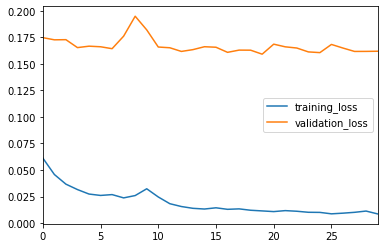

In [17]:
task = 'rlm_clearance[mL.min-1.g-1]'
split = 'Set_rlm'

(train_idx, valid_idx, test_idx), Y = get_idx_and_Y(df, task, split)

trainY = Y[train_idx]
validY = Y[valid_idx]
testY = Y[test_idx]

trainX = (X1[train_idx], X2[train_idx])
validX = (X1[valid_idx], X2[valid_idx])
testX  = (X1[test_idx], X2[test_idx])


#model = DoublePathModel(molmap1_size, molmap2_size, n_outputs = Y.shape[1])
#model = SinglePathModel(molmap_size, n_outputs = Y.shape[1])
from cbks import RegressionPerformance, EarlyStoppingAtMinLoss

earlystop = EarlyStoppingAtMinLoss(patience=10, criteria = 'val_loss')
performace = RegressionPerformance((trainX, trainY), (validX, validY), MASK = 1e8)
lr = tf.keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0) #
#model.compile(optimizer = lr, loss = 'mse')

model.load_weights('./basemodel.h5')
model.fit(trainX, trainY, batch_size=128, 
      epochs=task_epochs, verbose= 0, shuffle = True, 
      validation_data = (validX, validY), 
      callbacks=[performace, earlystop]) #

dfp = pd.DataFrame(performace.history)[['training_loss', 'validation_loss']]
dfp.plot()

In [19]:
performace.evaluate(trainX, trainY) # RMSE, R^2

([0.0972633666511306], [0.9851837898634245])

In [20]:
performace.evaluate(validX, validY) # RMSE, R^2

([0.39900672996308106], [0.7477203936104417])

In [21]:
performace.evaluate(testX, testY) # RMSE, R^2

([0.3425560217813767], [0.7948089031445207])

## 03.branch training for task of mlm

617 117 56
epoch: 0001, loss: 0.1062 - val_loss: 0.2195; rmse: 0.2866 - rmse_val: 0.4686;  r2: 0.8896 - r2_val: 0.6403                                                                                                    
epoch: 0002, loss: 0.0867 - val_loss: 0.2441; rmse: 0.2890 - rmse_val: 0.4941;  r2: 0.9094 - r2_val: 0.6327                                                                                                    
epoch: 0003, loss: 0.0678 - val_loss: 0.2261; rmse: 0.2518 - rmse_val: 0.4755;  r2: 0.9224 - r2_val: 0.6325                                                                                                    
epoch: 0004, loss: 0.0550 - val_loss: 0.2058; rmse: 0.2147 - rmse_val: 0.4537;  r2: 0.9340 - r2_val: 0.6409                                                                                                    
epoch: 0005, loss: 0.0411 - val_loss: 0.2105; rmse: 0.2059 - rmse_val: 0.4589;  r2: 0.9431 - r2_val: 0.6430                                                  

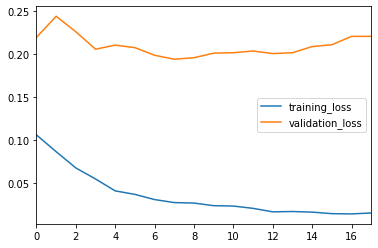

In [22]:
task = 'mlm_clearance[mL.min-1.g-1]'
split = 'Set_mlm'


(train_idx, valid_idx, test_idx), Y = get_idx_and_Y(df, task, split)

trainY = Y[train_idx]
validY = Y[valid_idx]
testY = Y[test_idx]

trainX = (X1[train_idx], X2[train_idx])
validX = (X1[valid_idx], X2[valid_idx])
testX  = (X1[test_idx], X2[test_idx])


#model = DoublePathModel(molmap1_size, molmap2_size, n_outputs = Y.shape[1])
#model = SinglePathModel(molmap_size, n_outputs = Y.shape[1])
from cbks import RegressionPerformance, EarlyStoppingAtMinLoss

earlystop = EarlyStoppingAtMinLoss(patience=10, criteria = 'val_loss')
performace = RegressionPerformance((trainX, trainY), (validX, validY), MASK = 1e8)
lr = tf.keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0) #
#model.compile(optimizer = lr, loss = 'mse')

model.load_weights('./basemodel.h5')
model.fit(trainX, trainY, batch_size=128, 
      epochs=task_epochs, verbose= 0, shuffle = True, 
      validation_data = (validX, validY), 
      callbacks=[performace, earlystop]) #

dfp = pd.DataFrame(performace.history)[['training_loss', 'validation_loss']]
dfp.plot()

In [23]:
performace.evaluate(trainX, trainY) # RMSE, R^2

([0.16281332874987348], [0.9613257943225114])

In [24]:
performace.evaluate(validX, validY) # RMSE, R^2

([0.4406488647575921], [0.6364576115616642])

In [25]:
performace.evaluate(testX, testY) # RMSE, R^2

([0.523125967247297], [0.4879611179209996])

In [26]:
model.count_params()

807841